# 赛题二：模型微调指导

    本赛题要求基于开源中英文混合数学运算数据集，跑通baseline，并对MindFormers中LLama3-8b模型进行微调（LoRA或其他微调算法）。

---

    特别说明：如果在一个全新环境下运行，从obs解压后，带*标记的步骤可以不用执行

---


## 环境配置

### 下载mindformers

    如果已经存在则可跳过这一步

In [ ]:
!wget https://2024-ascend-innovation-contest-mindspore.obs.cn-southwest-2.myhuaweicloud.com/topic2-finetune/mindformers.zip
!unzip mindformers.zip

### 环境准备

    每一次启动镜像都需要执行下面这些命令，以完成环境的初始化：

- mindspore

In [1]:
!pip install mindspore==2.3.0RC2

Looking in indexes: http://pip.modelarts.private.com:8888/repository/pypi/simple
     |████████████████████████████████| 244.0 MB 61.0 MB/s eta 0:00:01
  Attempting uninstall: mindspore
    Found existing installation: mindspore 2.3.0rc4
    Uninstalling mindspore-2.3.0rc4:
      Successfully uninstalled mindspore-2.3.0rc4
You should consider upgrading via the '/home/ma-user/anaconda3/envs/MindSpore/bin/python3.9 -m pip install --upgrade pip' command.


- mindformers

In [ ]:
%cd /home/ma-user/work/mindformers/
!bash build.sh

- 环境变量设置

In [3]:
!export PYTHONPATH="${PYTHONPATH}:/home/ma-user/work/mindformers/"

- tiktoken

In [4]:
!pip install tiktoken

Looking in indexes: http://pip.modelarts.private.com:8888/repository/pypi/simple
     |████████████████████████████████| 1.0 MB 67.9 MB/s eta 0:00:01
You should consider upgrading via the '/home/ma-user/anaconda3/envs/MindSpore/bin/python3.9 -m pip install --upgrade pip' command.


## 模型权重和 tokenizer 文件准备

    准备文件夹

In [7]:
%cd /home/ma-user/work/
!mkdir model

/home/ma-user/work
mkdir: cannot create directory ‘model’: File exists


### 下载权重文件

In [8]:

!wget https://2024-ascend-innovation-contest-mindspore.obs.cn-southwest-2.myhuaweicloud.com/topic2-finetune/llama3-8B.ckpt \
-P ./model

--2024-07-27 08:55:17--  https://2024-ascend-innovation-contest-mindspore.obs.cn-southwest-2.myhuaweicloud.com/topic2-finetune/llama3-8B.ckpt
Resolving 2024-ascend-innovation-contest-mindspore.obs.cn-southwest-2.myhuaweicloud.com (2024-ascend-innovation-contest-mindspore.obs.cn-southwest-2.myhuaweicloud.com)... 100.125.81.3, 100.125.81.67, 100.125.81.35
Connecting to 2024-ascend-innovation-contest-mindspore.obs.cn-southwest-2.myhuaweicloud.com (2024-ascend-innovation-contest-mindspore.obs.cn-southwest-2.myhuaweicloud.com)|100.125.81.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16060541933 (15G) [binary/octet-stream]
Saving to: ‘./model/llama3-8B.ckpt’

llama3-8B.ckpt      100%[===================>]  14.96G   226MB/s    in 76s     

2024-07-27 08:56:33 (203 MB/s) - ‘./model/llama3-8B.ckpt’ saved [16060541933/16060541933]



### tokenizer文件的下载命令

In [8]:
!wget https://2024-ascend-innovation-contest-mindspore.obs.cn-southwest-2.myhuaweicloud.com/topic2-finetune/tokenizer.model -P ./model 

--2024-07-25 18:53:24--  https://2024-ascend-innovation-contest-mindspore.obs.cn-southwest-2.myhuaweicloud.com/topic2-finetune/tokenizer.model
Resolving 2024-ascend-innovation-contest-mindspore.obs.cn-southwest-2.myhuaweicloud.com (2024-ascend-innovation-contest-mindspore.obs.cn-southwest-2.myhuaweicloud.com)... 100.125.81.3, 100.125.81.35, 100.125.81.67
Connecting to 2024-ascend-innovation-contest-mindspore.obs.cn-southwest-2.myhuaweicloud.com (2024-ascend-innovation-contest-mindspore.obs.cn-southwest-2.myhuaweicloud.com)|100.125.81.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2183982 (2.1M) [binary/octet-stream]
Saving to: ‘./model/tokenizer.model’

tokenizer.model     100%[===================>]   2.08M  --.-KB/s    in 0.01s   

2024-07-25 18:53:24 (206 MB/s) - ‘./model/tokenizer.model’ saved [2183982/2183982]



## 数据集准备

    如果文件已经存在则可以不用执行

In [ ]:
%cd /home/ma-user/work/
!mkdir data


### 下载原始数据集 *

In [ ]:
!cd /home/ma-user/work/

!wget https://2024-ascend-innovation-contest-mindspore.obs.cn-southwest-2.myhuaweicloud.com/topic2-finetune/train.json -P /home/ma-user/work/data
!wget https://2024-ascend-innovation-contest-mindspore.obs.cn-southwest-2.myhuaweicloud.com/topic2-finetune/data_converter.py -P /home/ma-user/work/data


### 添加 prompt 模板 *


In [4]:
#添加prompt
!python /home/ma-user/work/data/add_prompt.py \
--input /home/ma-user/work/data/train_150k.json \
--output /home/ma-user/work/data/train_150k_with_prompt.json

#转换数据
!python /home/ma-user/work/data/data_converter.py \
--data_path /home/ma-user/work/data/train_150k_with_prompt.json \
--output_path /home/ma-user/work/data/train_150k_with_prompt-data-conversation.json


### 转化为mindrecord格式
    此处在jupyter notebook内，常常中断，但是实际上在运行，建议在控制台执行命令：
```markdown  
    ```bash  
    cd /home/ma-user/work/mindformers  
    python research/llama3/llama_preprocess.py \  
        --dataset_type qa \  
        --input_glob /home/ma-user/work/data/train_150k_with_prompt-data-conversation.json \  
        --model_file /home/ma-user/work/tokenizer.model \  
        --seq_length 256 \  
        --output_file /home/ma-user/work/data/train_150k-fastchat256.mindrecord
    ```
```



In [ ]:
%cd /home/ma-user/work/mindformers/research/llama3/
!python llama_preprocess.py \
--dataset_type qa \
--input_glob /home/ma-user/work/data/train_150k_with_prompt-data-conversation.json \
--model_file /home/ma-user/work/model/tokenizer.model \
--seq_length 256 \
--output_file /home/ma-user/work/data/train_150k_with_prompt-fastchat256.mindrecord

/home/ma-user/anaconda3/envs/MindSpore/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/home/ma-user/work/mindformers/research/llama3
/home/ma-user/anaconda3/envs/MindSpore/lib/python3.9/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/ma-user/anaconda3/envs/MindSpore/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/ma-user/anaconda3/envs/MindSpore/lib/python3.9/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/ma-user/anaconda3/envs/MindSpore/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnor

## 修改配置文件并启动微调

### 下载微调配置文件 *

    如果以及存在，则不必执行

In [5]:
%cd /home/ma-user/work
!wget https://2024-ascend-innovation-contest-mindspore.obs.cn-southwest-2.myhuaweicloud.com/topic2-finetune/run_llama3_8b_8k_800T_A2_64G_lora_dis_256.yaml

/home/ma-user/work
--2024-07-22 13:18:33--  https://2024-ascend-innovation-contest-mindspore.obs.cn-southwest-2.myhuaweicloud.com/topic2-finetune/run_llama3_8b_8k_800T_A2_64G_lora_dis_256.yaml
Resolving 2024-ascend-innovation-contest-mindspore.obs.cn-southwest-2.myhuaweicloud.com (2024-ascend-innovation-contest-mindspore.obs.cn-southwest-2.myhuaweicloud.com)... 100.125.81.35, 100.125.81.67, 100.125.81.3
Connecting to 2024-ascend-innovation-contest-mindspore.obs.cn-southwest-2.myhuaweicloud.com (2024-ascend-innovation-contest-mindspore.obs.cn-southwest-2.myhuaweicloud.com)|100.125.81.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5195 (5.1K) [text/yaml]
Saving to: ‘run_llama3_8b_8k_800T_A2_64G_lora_dis_256.yaml.2’

run_llama3_8b_8k_80 100%[===================>]   5.07K  --.-KB/s    in 0s      

2024-07-22 13:18:33 (155 MB/s) - ‘run_llama3_8b_8k_800T_A2_64G_lora_dis_256.yaml.2’ saved [5195/5195]



### 启动训练
---
- config：指定配置文件路径
- load_checkpoint：指定模型路径
- train_data：指定训练数据路径

---
    特别说明：不要直接在jupyter notebook内执行下面这段脚本，最好在控制台上执行

In [ ]:
%cd /home/ma-user/work/mindformers/research/
!bash ../scripts/msrun_launcher.sh \
"llama3/run_llama3.py \
--config /home/ma-user/work/run_llama3_8b_8k_800T_A2_64G_lora_dis_256.yaml \
--load_checkpoint /home/ma-user/work/model/llama3-8B.ckpt \
--auto_trans_ckpt False \
--use_parallel True \
--run_mode finetune \
--train_data /home/ma-user/work/data/train_150k-fastchat256.mindrecord" 4

### 绘制损失曲线

    可以在训练过程中执行，可视化损失下降情况

/home/ma-user/anaconda3/envs/MindSpore/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/home/ma-user/work


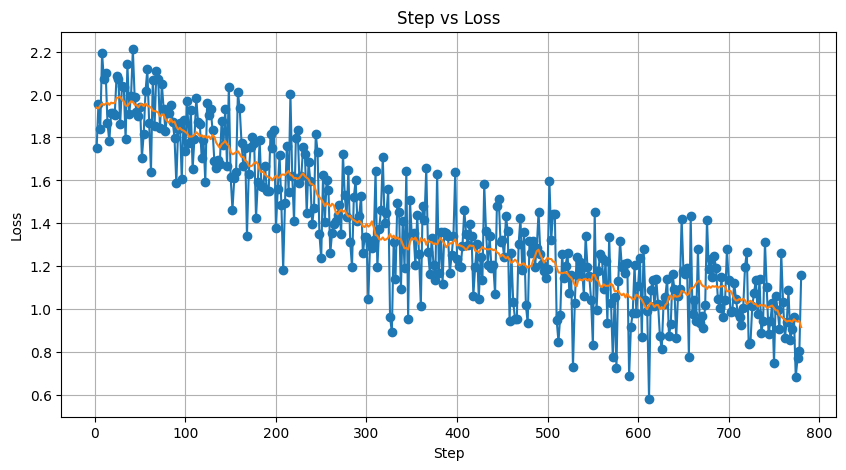

In [2]:
%cd /home/ma-user/work
import step_loss_plot as slp
step_loss_pairs = slp.parse_log_for_step_loss('mindformers/research/output/msrun_log/worker_0.log')
slp.plot_step_loss(step_loss_pairs,10)

### 权重合并
    训练结束后，对权重进行合并

In [6]:
%cd /home/ma-user/work/mindformers/
!python mindformers/tools/transform_ckpt.py \
--src_ckpt_strategy /home/ma-user/work/mindformers/research/output/strategy/ \
--src_ckpt_dir /home/ma-user/work/mindformers/research/output/checkpoint_network/ \
--dst_ckpt_dir /home/ma-user/work/model/ \
--prefix "new_lora_checkpoint_"

/home/ma-user/anaconda3/envs/MindSpore/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/home/ma-user/work/mindformers
/home/ma-user/anaconda3/envs/MindSpore/lib/python3.9/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/ma-user/anaconda3/envs/MindSpore/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/ma-user/anaconda3/envs/MindSpore/lib/python3.9/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/ma-user/anaconda3/envs/MindSpore/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
src_ckpt_st

## 微调后模型原有能力评估


### 获取数据集 *

In [2]:
%cd /home/ma-user/work/data
!wget https://2024-ascend-innovation-contest-mindspore.obs.cn-southwest-2.myhuaweicloud.com/topic2-finetune/squad1.1.zip
!unzip /home/ma-user/work/data/squad1.1.zip


/home/ma-user/anaconda3/envs/MindSpore/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/home/ma-user/work/data
--2024-07-22 16:04:40--  https://2024-ascend-innovation-contest-mindspore.obs.cn-southwest-2.myhuaweicloud.com/topic2-finetune/squad1.1.zip
Resolving 2024-ascend-innovation-contest-mindspore.obs.cn-southwest-2.myhuaweicloud.com (2024-ascend-innovation-contest-mindspore.obs.cn-southwest-2.myhuaweicloud.com)... 100.125.81.3, 100.125.81.35, 100.125.81.67
Connecting to 2024-ascend-innovation-contest-mindspore.obs.cn-southwest-2.myhuaweicloud.com (2024-ascend-innovation-contest-mindspore.obs.cn-southwest-2.myhuaweicloud.com)|100.125.81.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9152254 (8.7M) [application/zip]
Saving to: ‘squad1.1.zip.1’

squad1.1.zip.1      100%[===================>]   8.73M  --.-KB/s    in 0.07s   

2024-07-22 16:04:40 (117 MB/s) - ‘squad1.1.zip.1’ saved [9152254/9152254]

Archive:  /home/ma-user/work/data/squad1.1.zip
  inflating: dev-v1.1.json           
  inflating: train-v1.1.json         


### 处理数据成 mindrecord 格式 *

    以下内容需要在控制台执行

In [1]:
%cd /home/ma-user/work/

!python squad_data_process.py \
--input_file /home/ma-user/work/data/dev-v1.1.json \
--output_file /home/ma-user/work/data/squad8192.mindrecord \
--mode eval \
--max_length 8192 \
--tokenizer_type "llama3-8B" > test_eval_base.log 2>&1 &

/home/ma-user/anaconda3/envs/MindSpore/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/home/ma-user/work


OSError: Background processes not supported.

### 加载lora微调的配置文件 *

In [2]:

%cd /home/ma-user/work/
!wget https://2024-ascend-innovation-contest-mindspore.obs.cn-southwest-2.myhuaweicloud.com/topic2-finetune/run_llama3_8b_8k_800T_A2_64G_lora_256_base_eval.yaml


/home/ma-user/work
--2024-07-22 16:22:51--  https://2024-ascend-innovation-contest-mindspore.obs.cn-southwest-2.myhuaweicloud.com/topic2-finetune/run_llama3_8b_8k_800T_A2_64G_lora_256_base_eval.yaml
Resolving 2024-ascend-innovation-contest-mindspore.obs.cn-southwest-2.myhuaweicloud.com (2024-ascend-innovation-contest-mindspore.obs.cn-southwest-2.myhuaweicloud.com)... 100.125.81.67, 100.125.81.35, 100.125.81.3
Connecting to 2024-ascend-innovation-contest-mindspore.obs.cn-southwest-2.myhuaweicloud.com (2024-ascend-innovation-contest-mindspore.obs.cn-southwest-2.myhuaweicloud.com)|100.125.81.67|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5443 (5.3K) [text/yaml]
Saving to: ‘run_llama3_8b_8k_800T_A2_64G_lora_256_base_eval.yaml’

run_llama3_8b_8k_80 100%[===================>]   5.32K  --.-KB/s    in 0s      

2024-07-22 16:22:51 (117 MB/s) - ‘run_llama3_8b_8k_800T_A2_64G_lora_256_base_eval.yaml’ saved [5443/5443]



### 开启评测

In [ ]:
%cd /home/ma-user/work/mindformers
!python run_mindformer.py \
--config /home/ma-user/work/run_llama3_8b_8k_800T_A2_64G_lora_256_base_eval.yaml \
--eval_dataset_dir /home/ma-user/work/data/squad8192.mindrecord \
--run_mode eval \
--load_checkpoint /home/ma-user/work/model/rank_0/new_lora_checkpoint_0.ckpt \
--epochs 1 \
--batch_size 1 \
--use_parallel False \
--device_id 0 \
> /home/ma-user/work/log/dev-v1.1_eval.log 2>&1 &

## 微调参数比例计算

    模型微调参数的数量可在运行日志中获取

In [2]:
%cd /home/ma-user/work/mindformers/research/output/msrun_log
!cat worker_0.log |grep "Network Parameters"

/home/ma-user/anaconda3/envs/MindSpore/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/home/ma-user/work/mindformers/research/output/msrun_log
2024-07-26 09:01:38,390 - mindformers[mindformers/trainer/base_trainer.py:543] - INFO - Network Parameters: 7077888.


## 运行推理

### 下载推理配置 *
（如果已经存在则不用执行）

In [5]:

%cd /home/ma-user/work
!wget https://2024-ascend-innovation-contest-mindspore.obs.cn-southwest-2.myhuaweicloud.com/topic2-finetune/run_llama3_test.py


!wget https://2024-ascend-innovation-contest-mindspore.obs.cn-southwest-2.myhuaweicloud.com/topic2-finetune/run_llama3_8b_8k_800T_A2_64G_lora_256_eval.yaml

/home/ma-user/work
--2024-07-22 17:09:14--  https://2024-ascend-innovation-contest-mindspore.obs.cn-southwest-2.myhuaweicloud.com/topic2-finetune/run_llama3_test.py
Resolving 2024-ascend-innovation-contest-mindspore.obs.cn-southwest-2.myhuaweicloud.com (2024-ascend-innovation-contest-mindspore.obs.cn-southwest-2.myhuaweicloud.com)... 100.125.81.35, 100.125.81.67, 100.125.81.3
Connecting to 2024-ascend-innovation-contest-mindspore.obs.cn-southwest-2.myhuaweicloud.com (2024-ascend-innovation-contest-mindspore.obs.cn-southwest-2.myhuaweicloud.com)|100.125.81.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10718 (10K) [application/octet-stream]
Saving to: ‘run_llama3_test.py.1’

run_llama3_test.py. 100%[===================>]  10.47K  --.-KB/s    in 0s      

2024-07-22 17:09:14 (172 MB/s) - ‘run_llama3_test.py.1’ saved [10718/10718]

--2024-07-22 17:09:14--  https://2024-ascend-innovation-contest-mindspore.obs.cn-southwest-2.myhuaweicloud.com/topic2-finetune/ru

### 执行推理


In [ ]:
%cd /home/ma-user/work
!python run_llama3_test.py \
--config /home/ma-user/work/run_llama3_8b_8k_800T_A2_64G_lora_256_eval.yaml \
--run_mode predict \
--use_parallel False \
--load_checkpoint /home/ma-user/work/model/rank_0/new_lora_checkpoint_1200.ckpt \
--vocab_file /home/ma-user/work/model/tokenizer.model \
--auto_trans_ckpt False \
--input_dir "/home/ma-user/work/data/test_100.json"
> /home/ma-user/work/log/data_test_2000_1.log 2>&1 &

## 上传OBS桶

### 压缩代码及配置文件

In [ ]:
%cd /home/ma-user/work
!zip -r lora-fine-tuning.zip \
./data \
./img \
./log \
./mindformers/research/output/msrun_log \
llama3_tokenizer.py \
run_llama3_8b_8k_800T_A2_64G_lora_256_base_eval.yaml \
run_llama3_8b_8k_800T_A2_64G_lora_256_eval.yaml \
run_llama3_8b_8k_800T_A2_64G_lora_dis_256.yaml \
run_llama3_test.py \
run.ipynb \
squad_data_process.py \
step_loss_plot.py \
eval.ipynb \
result_npy.npy \
accurate_evaluation.py \
result_npy_base.npy \




/home/ma-user/work
  adding: data/ (stored 0%)
  adding: data/.ipynb_checkpoints/ (stored 0%)
  adding: data/.ipynb_checkpoints/add_prompt-checkpoint.py (deflated 45%)
  adding: data/.ipynb_checkpoints/train_150k_with_prompt-data-conversation-checkpoint.json (deflated 95%)
  adding: data/.ipynb_checkpoints/data_converter-checkpoint.py (deflated 61%)
  adding: data/.ipynb_checkpoints/dev-v1.1-checkpoint.json (deflated 79%)
  adding: data/.ipynb_checkpoints/train_150k-data-conversation-checkpoint.json (deflated 93%)
  adding: data/test_16.json (deflated 58%)
  adding: data/train_150k-fastchat256.mindrecord.db (deflated 63%)
  adding: data/data_converter.py (deflated 64%)
  adding: data/train_150k-fastchat256.mindrecord (deflated 96%)
  adding: data/train_150k-data-conversation.json (deflated 93%)
  adding: data/test_128.json (deflated 74%)
  adding: data/squad1.1.zip (stored 0%)
  adding: data/dev-v1.1.json (deflated 79%)
  adding: data/train.json

### 上传压缩包

In [12]:
import moxing as mox
#上传一个OBS文件obs_file.txt，从Notebook上传至OBS
mox.file.copy('lora-fine-tuning.zip', 'obs://llama3/lora-fine-tuning.zip')

### 上传模型权重

In [4]:
import moxing as mox
#上传一个OBS文件obs_file.txt，从Notebook上传至OBS
mox.file.copy('model/rank_0/new_lora_checkpoint_0.ckpt', 'obs://llama3/new_lora_checkpoint_0.ckpt')

## 进程查看指令

In [2]:
!ps aux | grep python

ma-user      233  0.6  0.0 449628 82692 ?        Sl   15:23   0:08 /modelarts/authoring/notebook-conda/bin/python /modelarts/authoring/notebook-conda/bin/jupyter-kernelgateway --KernelGatewayApp.ip=172.16.0.182 --KernelGatewayApp.port=8889 --KernelGatewayApp.api=kernel_gateway.jupyter_websocket --KernelGatewayApp.auth_token=c5014b8648f1efb2eaef197a64a22d8e8af5a144bb24889b4bad154847b6584e-37b6c835eb6863e4c3daa208a27ef3fc --JupyterWebsocketPersonality.list_kernels=True --debug
ma-user      261  4.2  0.0 42882312 165432 ?     Sl   15:23   0:58 /modelarts/authoring/notebook-conda/bin/python /modelarts/authoring/notebook-conda/bin/jupyter-lab --config=/modelarts/authoring/notebook-conda/etc/jupyter/jupyter_notebook_config.py --app-dir=/home/ma-user/.lab/console
ma-user     2334  0.7  0.0 1072196 83372 ?       Ssl  15:25   0:09 /home/ma-user/anaconda3/envs/MindSpore/bin/python -m ipykernel -f /home/ma-user/.local/share/jupyter/runtime/kernel-79e4e271-44db-42e5-9039-56b9eff39470.json
ma-user 